# Filters Exploration

In [1]:
import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import numpy as np
from kymatio.scattering2d.core.scattering2d import scattering2d
from parametricSN.models.models_utils import get_filters_visualization
from parametricSN.models.create_filters import *
import matplotlib.pyplot as plt
from kymatio import Scattering2D
import torch


## 1. Create Filters

In [61]:
J=3
M=32
N=32
requires_grad= False
equivariance = True
device=None
initialization = "Tight-Frame"    
scattering = Scattering2D(J=J, shape=(M, N), frontend='torch')
L = scattering.L
n_coefficients=  L*L*J*(J-1)//2 + 1 + L*J  
K = n_coefficients*3
_, psi  = scattering.load_filters()
if initialization == "Tight-Frame":
    params_filters = create_filters_params(J,L,requires_grad, equivariance, device) #kymatio init
elif initialization == "Random":
    params_filters = create_filters_params_random(J,L,requires_grad,equivariance,device) #random init
else:
    raise InvalidInitializationException
shape = (scattering.M_padded, scattering.N_padded,)
ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
grid = torch.stack(torch.meshgrid(*ranges), 0).to(device)
params_filters =  [ param.to(device) for param in params_filters]


In [131]:
def create_psi(J=2, M=32, N=32, requires_grad= False, equivariance = False, device=None, initialization = "Random"):
    scattering = Scattering2D(J=J, shape=(M, N), frontend='torch')
    L = scattering.L
    n_coefficients=  L*L*J*(J-1)//2 + 1 + L*J  
    K = n_coefficients*3
    _, psi  = scattering.load_filters()
    if initialization == "Tight-Frame":
        params_filters = create_filters_params(J,L,requires_grad, equivariance, device) #kymatio init
    elif initialization == "Random":
        params_filters = create_filters_params_random(J,L,requires_grad,equivariance,device) #random init
    else:
        raise InvalidInitializationException
    shape = (scattering.M_padded, scattering.N_padded,)
    ranges = [torch.arange(-(s // 2), -(s // 2) + s, device=device, dtype=torch.float) for s in shape]
    grid = torch.stack(torch.meshgrid(*ranges), 0).to(device)
    params_filters =  [ param.to(device) for param in params_filters]
    
    if equivariance:
        for i,d in enumerate(psi):
            for res in range(0, J-1):
                if res in d.keys():
                    if res == 0:
                        orientation = (params_filters[0][d['j']] + d['theta']*(np.pi/8)).unsqueeze(0)
                        d[res] = morlets(shape, orientation, 
                                         params_filters[1][d['j']].unsqueeze(0), 
                                         params_filters[2][d['j']].unsqueeze(0),
                                         params_filters[3][d['j']].unsqueeze(0) )
                    else:
                        d[res] = periodize_filter_fft(d[0].squeeze(0), res, device).unsqueeze(2)
        return psi #update psi to reflect the new conv filters,params_filters
    else:
        wavelets  = morlets(shape, params_filters[0], params_filters[1], 
                        params_filters[2], params_filters[3], device=device )

        return update_psi(J, psi, wavelets, device)

In [163]:
first = True
for i,d in enumerate(psi):
    for res in range(0, J-1):
        if res in d.keys():
            if res == 0:
                orientation = (params_filters[0][d['j']] + d['theta']*(np.pi/8)).unsqueeze(0)
                d[res] = morlets(shape, orientation, 
                                 params_filters[1][d['j']].unsqueeze(0), 
                                 params_filters[2][d['j']].unsqueeze(0),
                                 params_filters[3][d['j']].unsqueeze(0))
            
            else:
                d[res] = periodize_filter_fft(d[0].squeeze(0), res, device).unsqueeze(2)
            if first:
                wavelets = d[res]
                first = False
            else:
                wavelets=torch.cat((wavelets,d[res]))

In [164]:
params_filters[1][d['j']].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1])

In [189]:
num_filters = 0
for i,d in enumerate(psi):
    for res in range(0, J-1):
        if res in d.keys():
            if res == 0:
                orientation = (params_filters[0][d['j']] + d['theta']*(np.pi/8)).unsqueeze(0)
                d[res] = morlets(shape, orientation, 
                                 params_filters[1][d['j']].unsqueeze(0), 
                                 params_filters[2][d['j']].unsqueeze(0),
                                 params_filters[3][d['j']].unsqueeze(0) )
                num_filters+=1
            else:
                d[res] = periodize_filter_fft(d[0].squeeze(0), res, device).unsqueeze(2)
                num_filters+=1

In [190]:
num_filters

40

## 2. Visualize Filters 

In [166]:
print(f'if j=0 then sigma: {0.8 * 2**0}')
print(f'if j=1 then sigma: {0.8 * 2**1}')
print(f'if j=2 then sigma: {0.8 * 2**2}')
print(f'if j=0 then xi: {3.0 / 4.0 * np.pi /2**0}')
print(f'if j=1 then xi: {3.0 / 4.0 * np.pi /2**1}')
print(f'if j=2 then xi: {3.0 / 4.0 * np.pi /2**2}')
print(f'slant: {4.0/8}')   


if j=0 then sigma: 0.8
if j=1 then sigma: 1.6
if j=2 then sigma: 3.2
if j=0 then xi: 2.356194490192345
if j=1 then xi: 1.1780972450961724
if j=2 then xi: 0.5890486225480862
slant: 0.5


Possible values of 3 parameters when init = 'Random' (excluding orientation)

In [167]:
print(f'sigma between {np.log(np.exp(0.5))} and {np.log(np.exp(5))}')
print(f'xi between {0.5} and {1}')
print(f'slant between {0.5} and {1.5}')

   

sigma between 0.5 and 5.0
xi between 0.5 and 1
slant between 0.5 and 1.5


Possible values of 3 parameters when init='Random' (excluding orientation)

In [168]:
print(f'if j=0 then sigma value between {np.log(np.exp(0.5*(0+1)))} and {np.log(np.exp(3*(0+1)))}')
print(f'if j=1 then sigma value between {np.log(np.exp(0.5*(1+1)))} and {np.log(np.exp(3*(1+1)))}')
print(f'if j=2 then sigma value between {np.log(np.exp(0.5*(2+1)))} and {np.log(np.exp(3*(2+1)))}')
# print(f'if j=0 then xi value between {0.5*(J-0 +1)} and {0.75*(J-0+1)}')
# print(f'if j=1 then xi value between {0.5*(J-1+1)} and {0.75*(J-1+1)}')
# print(f'if j=2 then xi value between {0.5*(J-2+1)} and {1*(J-2+1)}')
print(f'xi between {0.5} and {1}')
print(f'slant between {0.5} and {1.5}')

if j=0 then sigma value between 0.5 and 3.0
if j=1 then sigma value between 1.0 and 6.0
if j=2 then sigma value between 1.5 and 9.0
xi between 0.5 and 1
slant between 0.5 and 1.5


In [191]:
J=2
L=8

### 2.1 Tight Frame Init + Equivariance + Equivariance = True
Value of 3 parameters when init = 'Tight-frame' (excluding orientation)

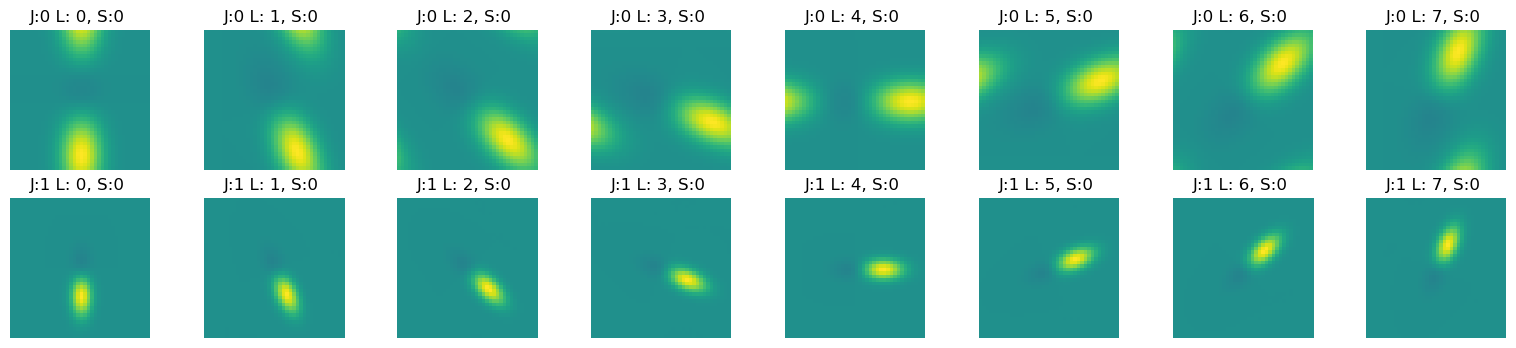

In [202]:
psi = create_psi(J=J,initialization = "Tight-Frame", equivariance = True)
get_filters_visualization(psi, J, L, mode ='fourier')

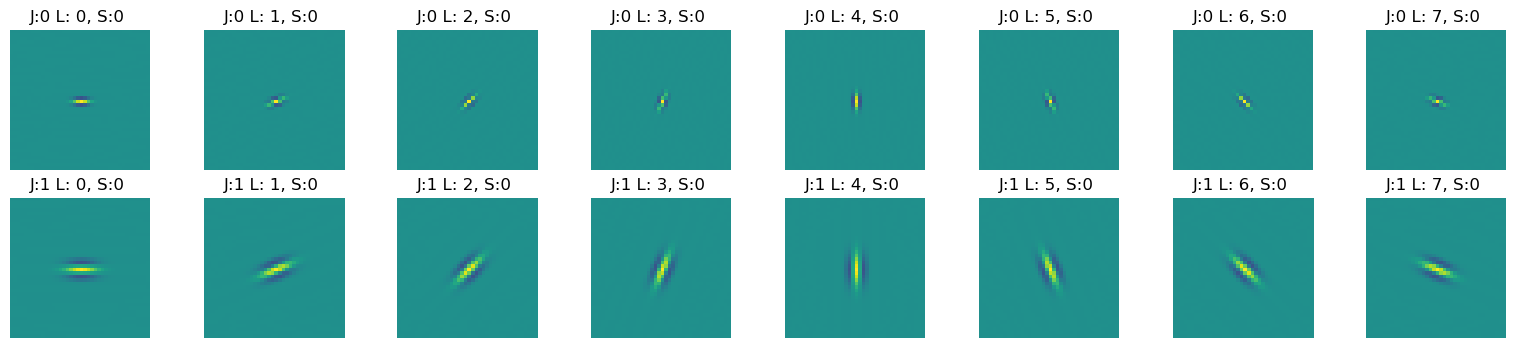

In [203]:
get_filters_visualization(psi, J, L, mode ='real')

### 2.2 Tight Frame Init + Equivariance + Equivariance = False

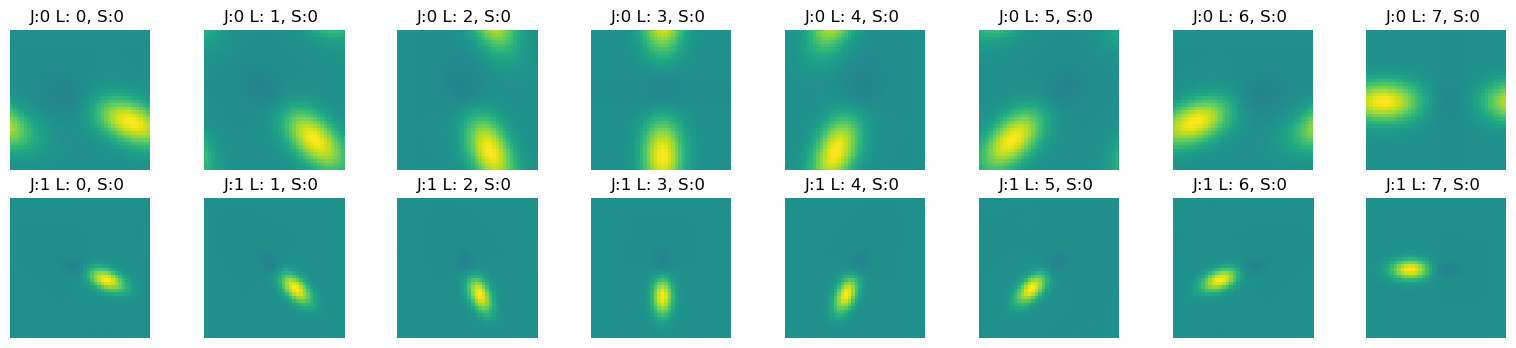

In [193]:
psi = create_psi(J=J,initialization = "Tight-Frame", equivariance = False)
get_filters_visualization(psi, J, L, mode ='fourier')

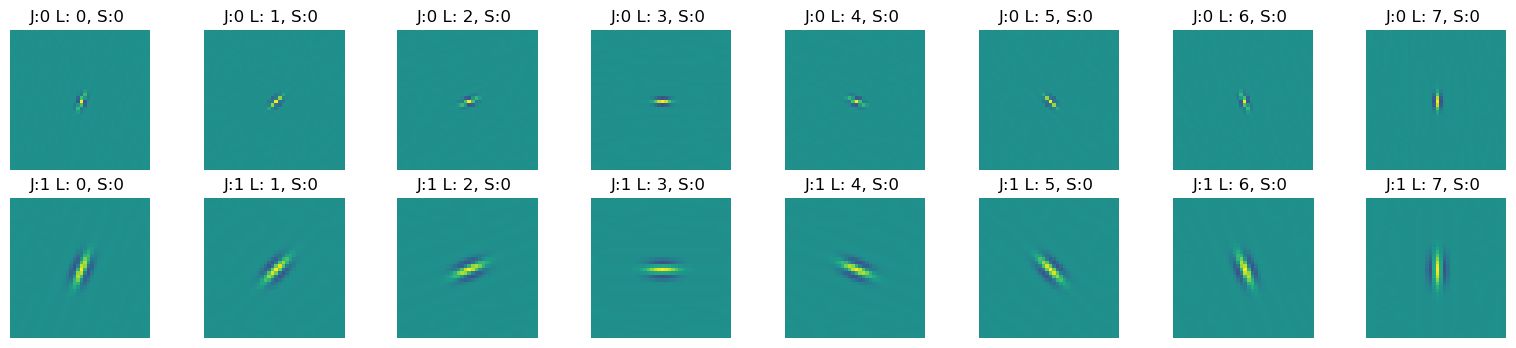

In [194]:
get_filters_visualization(psi, J, L, mode ='real')

### 2.3 Random Init + Equivariance + Equivariance = True

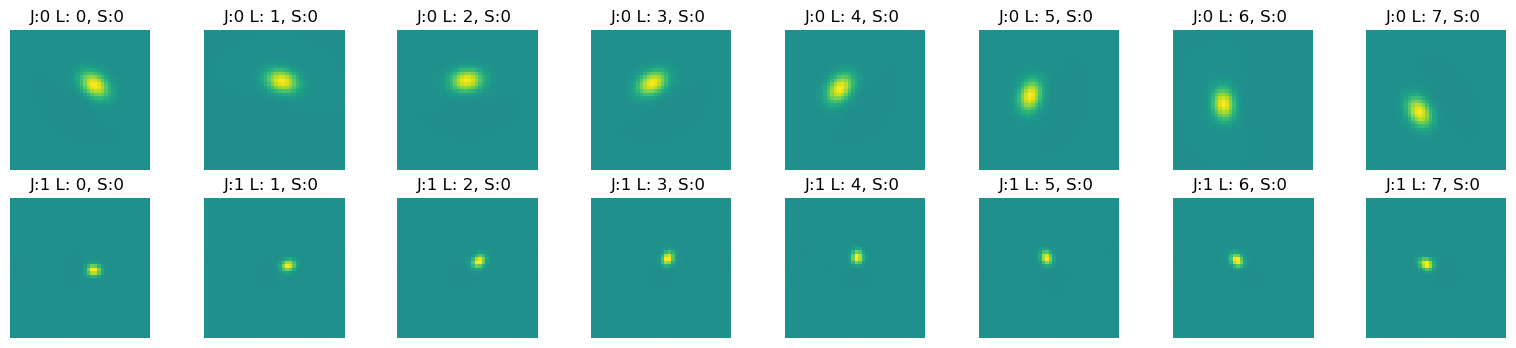

In [195]:
psi = create_psi(J=J, equivariance = True)
get_filters_visualization(psi, J, L, mode ='fourier')

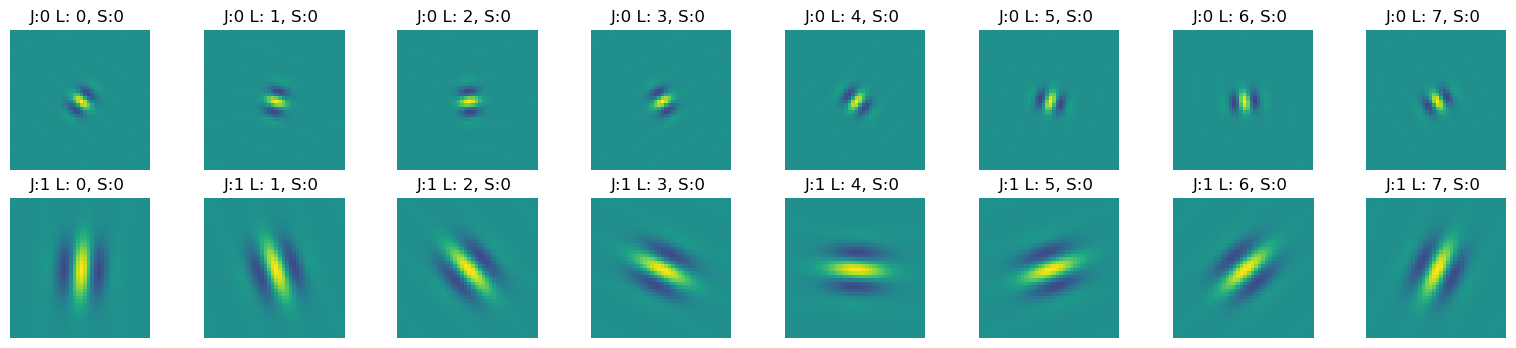

In [196]:
get_filters_visualization(psi, J, L, mode ='real')

### 2.4 Random Init + Equivariance + Equivariance = False

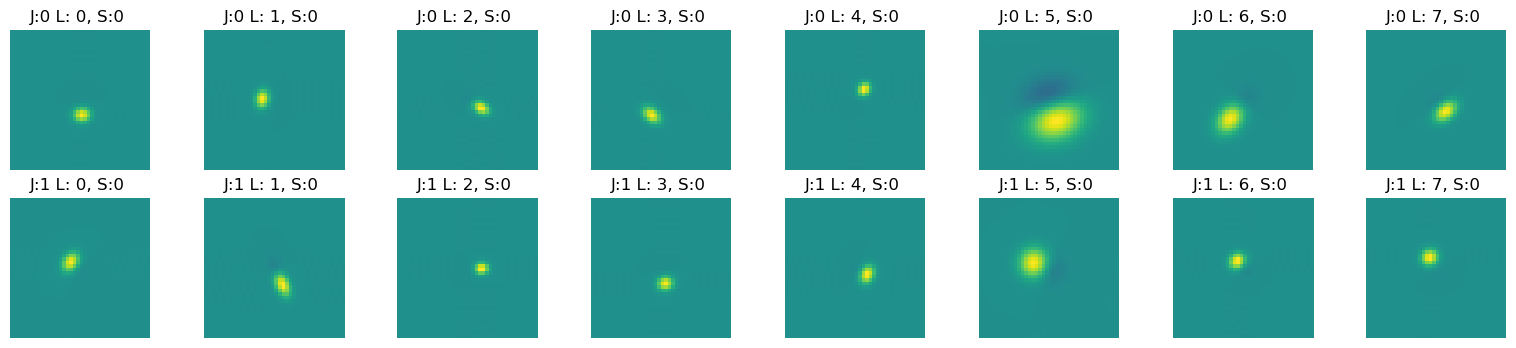

In [199]:
psi = create_psi(J=J, equivariance = False)
get_filters_visualization(psi, J, L, mode ='fourier')

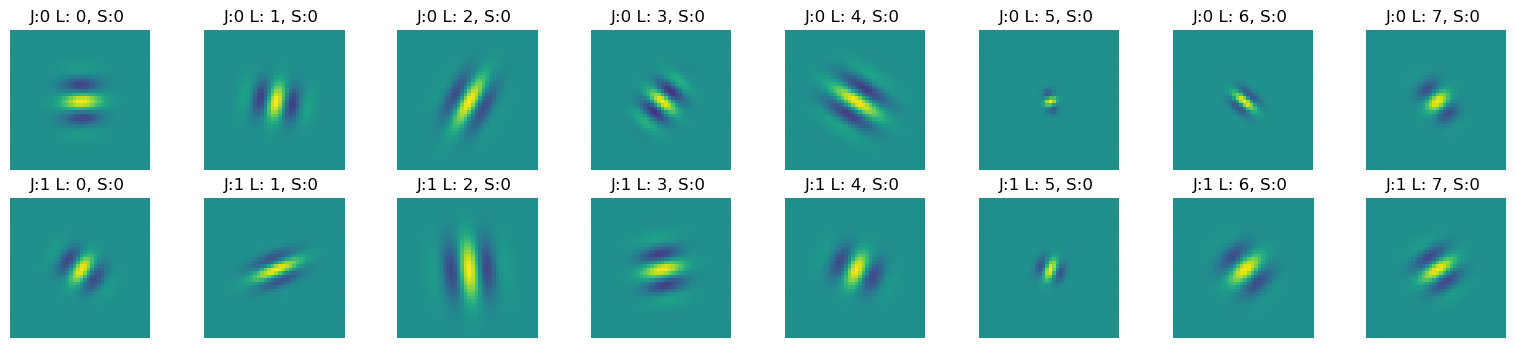

In [200]:
get_filters_visualization(psi, J, L, mode ='real')